In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/CT-GAN-mini

!pwd

!pip install pydicom

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CT-GAN-mini
/content/drive/MyDrive/CT-GAN-mini


In [ ]:
# Import necessary libraries
import os
import numpy as np
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

import pydicom
from skimage.transform import resize

# For mixed-precision training
from torch.amp import GradScaler, autocast

# Define epsilon to prevent division by zero
epsilon = 1e-8

In [ ]:
# Training hyperparameters
n_epochs = 50
batch_size = 4
lr = 0.0002
img_size = 256
ct_slices = 128
channels = 1
z_dim = 512  # Latent dimension for StyleGAN2

In [ ]:
# Dataset class
class XrayCTDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.patients = sorted(os.listdir(root_dir))
        # Filter out any files that are not directories
        self.patients = [p for p in self.patients if os.path.isdir(os.path.join(root_dir, p))]

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_id = self.patients[idx]
        patient_dir = os.path.join(self.root_dir, patient_id)

        # Load and preprocess X-ray image
        xray_path = glob(os.path.join(patient_dir, 'Xray', '*.dcm'))[0]
        xray = self.load_and_preprocess_image(xray_path)

        # Load and preprocess CT slices
        ct_dir = os.path.join(patient_dir, 'CT')
        ct_slice_paths = sorted(glob(os.path.join(ct_dir, '*.dcm')))
        ct_slices_array = self.load_and_preprocess_ct_slices(ct_slice_paths)

        # Debug statements
        print(f"Patient ID: {patient_id}")
        print(f"X-ray image min: {xray.min().item()}, max: {xray.max().item()}")
        print(f"CT slices min: {ct_slices_array.min().item()}, max: {ct_slices_array.max().item()}")

        sample = {'xray': xray, 'ct': ct_slices_array}

        return sample

    def load_and_preprocess_image(self, image_path):
        # Load the image
        if image_path.endswith('.dcm'):
            ds = pydicom.dcmread(image_path)
            image = ds.pixel_array.astype(np.float32)
        else:
            image = Image.open(image_path).convert('L')
            image = np.array(image).astype(np.float32)

        # Normalize the image
        image_min = image.min()
        image_max = image.max()
        if image_max - image_min < epsilon:
            image = np.zeros_like(image)
        else:
            image = (image - image_min) / (image_max - image_min + epsilon)
            # Scale to [-1, 1] if using Tanh activation
            image = image * 2 - 1

        # Resize the image
        image = resize(image, (img_size, img_size), mode='constant', anti_aliasing=True)

        # Convert to tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        return image

    def load_and_preprocess_ct_slices(self, slice_paths):
        num_slices = len(slice_paths)
        desired_slices = ct_slices

        # Calculate indices to select slices for alignment
        indices = np.linspace(0, num_slices - 1, desired_slices).astype(int)

        # Preallocate a list for the CT slices
        ct_slices_list = []
        for idx in indices:
            p = slice_paths[idx]
            # Load and preprocess each slice
            slice_ = self.load_and_preprocess_image(p)
            ct_slices_list.append(slice_)

        # Stack slices into a 3D volume
        ct_slices_array = torch.stack(ct_slices_list, dim=0)  # Shape: [ct_slices, 1, img_size, img_size]
        ct_slices_array = ct_slices_array.squeeze(1)  # Shape: [ct_slices, img_size, img_size]
        ct_slices_array = ct_slices_array.unsqueeze(0)  # Shape: [1, ct_slices, img_size, img_size]

        return ct_slices_array  # Return shape: [1, ct_slices, img_size, img_size]

In [ ]:
# Path to the dataset
dataset_root = 'LIDC-IDRI/'

# Create dataset and dataloader
dataset = XrayCTDataset(root_dir=dataset_root)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
class StyledGenerator(nn.Module):
    def __init__(self, z_dim, ct_slices, img_size, channels):
        super(StyledGenerator, self).__init__()
        self.ct_slices = ct_slices
        self.img_size = img_size

        # Mapping network for latent vector (reduced size)
        self.mapping = nn.Sequential(
            nn.Linear(z_dim, z_dim // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(z_dim // 2, z_dim // 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Encoding X-ray image to latent space (reduced channels)
        self.xray_encoder = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),        # 64x64
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, z_dim // 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Synthesis network to generate CT scans (reduced channels)
        self.synthesis = nn.Sequential(
            nn.Linear(z_dim, 128 * 4 * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, 4, 4, 4)),
            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8x8
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose3d(64, channels, kernel_size=4, stride=2, padding=1),  # 16x16x16
            nn.Tanh(),
        )

        # Final upsampling
        self.final_upsample = nn.Upsample(size=(ct_slices, img_size, img_size), mode='trilinear', align_corners=False)

    def forward(self, xray, z):
        z_mapped = self.mapping(z)
        xray_encoded = self.xray_encoder(xray)
        combined = torch.cat([z_mapped, xray_encoded], dim=1)
        ct_volume = self.synthesis(combined)
        ct_volume = self.final_upsample(ct_volume)
        return ct_volume

class StyledDiscriminator(nn.Module):
    def __init__(self, ct_slices, img_size, channels):
        super(StyledDiscriminator, self).__init__()

        self.ct_slices = ct_slices
        self.img_size = img_size

        # Encoding X-ray image to latent space (reduced channels)
        self.xray_encoder = nn.Sequential(
            nn.Conv2d(channels, 16, kernel_size=4, stride=2, padding=1),  # Output: [B,16,128,128]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),        # Output: [B,32,64,64]
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1),                                      # Output: [B,32,1,1]
            nn.Flatten(),                                                 # Output: [B,32]
        )

        # Discriminator network for CT scans (reduced channels)
        self.ct_discriminator = nn.Sequential(
            nn.Conv3d(channels, 32, kernel_size=4, stride=2, padding=1),  # Output: [B,32,D/2,128,128]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(32, 64, kernel_size=4, stride=2, padding=1),        # Output: [B,64,D/4,64,64]
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool3d(1),                                      # Output: [B,64,1,1,1]
            nn.Flatten(),                                                 # Output: [B,64]
        )

        # Final classifier (adjusted input size)
        self.classifier = nn.Sequential(
            nn.Linear(64 + 32, 256),  # Adjust input features to 96
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, ct, xray):
        xray_encoded = self.xray_encoder(xray)  # Shape: [B, 32]
        ct_encoded = self.ct_discriminator(ct)  # Shape: [B, 64]
        combined = torch.cat([ct_encoded, xray_encoded], dim=1)  # Shape: [B, 96]
        validity = self.classifier(combined)
        return validity


In [ ]:
# Initialize generator and discriminator
generator = StyledGenerator(z_dim=z_dim, ct_slices=ct_slices, img_size=img_size, channels=channels)
discriminator = StyledDiscriminator(ct_slices=ct_slices, img_size=img_size, channels=channels)

In [ ]:
# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters
print(f"Generator parameters: {count_parameters(generator)}")
print(f"Discriminator parameters: {count_parameters(discriminator)}")

Generator parameters: 4978081
Discriminator parameters: 166801


In [ ]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)

# Loss function
adversarial_loss = nn.BCEWithLogitsLoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.99))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0, 0.99))

# For mixed-precision training
scaler = GradScaler()
print(device)

cuda


In [ ]:
# Training loop
for epoch in range(n_epochs):
    for i, batch in enumerate(dataloader):
        xray = batch['xray'].to(device, non_blocking=True)
        ct = batch['ct'].to(device, non_blocking=True)

        # Reshape ct to [B, 1, ct_slices, img_size, img_size]
        ct = ct  # Shape already [B, 1, ct_slices, img_size, img_size]

        valid = torch.ones((xray.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((xray.size(0), 1), requires_grad=False).to(device)

        # Sample random noise
        z = torch.randn(xray.size(0), z_dim).to(device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        with autocast(device_type='cuda'):
            # Generate CT scans
            gen_ct = generator(xray, z)

            # Generator loss
            g_loss = adversarial_loss(discriminator(gen_ct, xray), valid)

        scaler.scale(g_loss).backward()
        scaler.step(optimizer_G)
        scaler.update()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        with autocast(device_type='cuda'):
            # Real CT loss
            real_loss = adversarial_loss(discriminator(ct, xray), valid)
            # Fake CT loss
            fake_loss = adversarial_loss(discriminator(gen_ct.detach(), xray), fake)
            # Total discriminator loss
            d_loss = 0.5 * (real_loss + fake_loss)

        scaler.scale(d_loss).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # Print training progress
        print(f"[Epoch {epoch+1}/{n_epochs}] [Batch {i+1}/{len(dataloader)}] "
              f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

# Save the models and optimizers
torch.save({
    'epoch': n_epochs,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
}, 'model_checkpoint.pth')


Görüntülenen çıkış son 5000 satıra kısaltıldı.
X-ray image min: -1.0, max: 0.8384372591972351
CT slices min: -1.0, max: 0.9999663233757019
Patient ID: LIDC-IDRI-0259
X-ray image min: -0.9506331086158752, max: 0.8409159779548645
CT slices min: -1.0, max: 1.0
Patient ID: LIDC-IDRI-0136
X-ray image min: -0.3910894989967346, max: 0.9361029863357544
CT slices min: -1.0, max: 0.9989639520645142
[Epoch 42/50] [Batch 46/48] [D loss: 0.4508] [G loss: 0.6524]
Patient ID: LIDC-IDRI-0155
X-ray image min: -0.979500412940979, max: 0.9286718964576721
CT slices min: -1.0, max: 1.0
Patient ID: LIDC-IDRI-0095
X-ray image min: -0.498353511095047, max: 0.9467958211898804
CT slices min: -0.9998184442520142, max: 0.9995657801628113
Patient ID: LIDC-IDRI-0253
X-ray image min: -0.9913284778594971, max: 0.719779908657074
CT slices min: -1.0, max: 1.0
Patient ID: LIDC-IDRI-0021
X-ray image min: -0.9916602969169617, max: 0.9022049903869629
CT slices min: -1.0, max: 1.0
[Epoch 42/50] [Batch 47/48] [D loss: 0.4797

In [ ]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

def visualize_results(generator, dataloader, device):
    generator.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            xray = batch['xray'].to(device, non_blocking=True)
            ct_real = batch['ct'].to(device, non_blocking=True)

            # Sample random noise
            z = torch.randn(xray.size(0), z_dim).to(device)

            # Generate CT scans
            gen_ct = generator(xray, z)

            # Select the first sample from the batch
            xray_np = xray[0].squeeze().cpu().numpy()        # Shape: [img_size, img_size]
            ct_real_np = ct_real[0].squeeze().cpu().numpy()  # Shape: [ct_slices, img_size, img_size]
            gen_ct_np = gen_ct[0].squeeze().cpu().numpy()    # Shape: [ct_slices, img_size, img_size]

            # Select a slice to visualize (e.g., middle slice)
            slice_idx = ct_slices // 2
            ct_real_slice = ct_real_np[slice_idx]
            gen_ct_slice = gen_ct_np[slice_idx]

            # Calculate PSNR and SSIM for the selected slice
            psnr_value = psnr(ct_real_slice, gen_ct_slice, data_range=gen_ct_slice.max() - gen_ct_slice.min())
            ssim_value = ssim(ct_real_slice, gen_ct_slice, data_range=gen_ct_slice.max() - gen_ct_slice.min())

            # Plot X-ray, real CT slice, and generated CT slice
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(xray_np, cmap='gray')
            axs[0].set_title('Input X-ray')
            axs[0].axis('off')

            axs[1].imshow(ct_real_slice, cmap='gray')
            axs[1].set_title('Real CT Slice')
            axs[1].axis('off')

            axs[2].imshow(gen_ct_slice, cmap='gray')
            axs[2].set_title(f'Generated CT Slice\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}')
            axs[2].axis('off')

            plt.show()

            # Visualize only one sample
            break

def calculate_metrics(generator, dataloader, device):
    generator.eval()
    mse_total = 0.0
    psnr_total = 0.0
    ssim_total = 0.0
    num_slices = 0

    with torch.no_grad():
        for batch in dataloader:
            xray = batch['xray'].to(device, non_blocking=True)
            ct_real = batch['ct'].to(device, non_blocking=True)

            # Sample random noise
            z = torch.randn(xray.size(0), z_dim).to(device)

            # Generate CT scans
            gen_ct = generator(xray, z)

            # Convert to numpy arrays
            ct_real_np = ct_real.cpu().numpy()  # Shape: [batch_size, 1, ct_slices, img_size, img_size]
            gen_ct_np = gen_ct.cpu().numpy()    # Shape: [batch_size, 1, ct_slices, img_size, img_size]

            # Remove singleton channel dimension
            ct_real_np = np.squeeze(ct_real_np, axis=1)  # Shape: [batch_size, ct_slices, img_size, img_size]
            gen_ct_np = np.squeeze(gen_ct_np, axis=1)    # Shape: [batch_size, ct_slices, img_size, img_size]

            # Loop over batch and slices
            batch_size = ct_real_np.shape[0]

            for b in range(batch_size):
                for s in range(ct_slices):
                    real_slice = ct_real_np[b, s]
                    gen_slice = gen_ct_np[b, s]

                    mse = np.mean((real_slice - gen_slice) ** 2)
                    psnr_value = psnr(real_slice, gen_slice, data_range=gen_slice.max() - gen_slice.min())
                    ssim_value = ssim(real_slice, gen_slice, data_range=gen_slice.max() - gen_slice.min())

                    mse_total += mse
                    psnr_total += psnr_value
                    ssim_total += ssim_value
                    num_slices += 1

    # Average the metrics
    mse_avg = mse_total / num_slices
    psnr_avg = psnr_total / num_slices
    ssim_avg = ssim_total / num_slices

    print(f"Average MSE: {mse_avg:.4f}")
    print(f"Average PSNR: {psnr_avg:.2f} dB")
    print(f"Average SSIM: {ssim_avg:.4f}")



Patient ID: LIDC-IDRI-0271
X-ray image min: -0.9764474034309387, max: 0.8027729392051697
CT slices min: -1.0, max: 1.0
Patient ID: LIDC-IDRI-0022
X-ray image min: -0.9844658374786377, max: 0.7746801376342773
CT slices min: -1.0, max: 1.0
Patient ID: LIDC-IDRI-0194
X-ray image min: -0.9952920079231262, max: 0.6989507079124451
CT slices min: -1.0, max: 0.9999978542327881
Patient ID: LIDC-IDRI-0008
X-ray image min: -0.9906158447265625, max: 0.9051004648208618
CT slices min: -1.0, max: 1.0


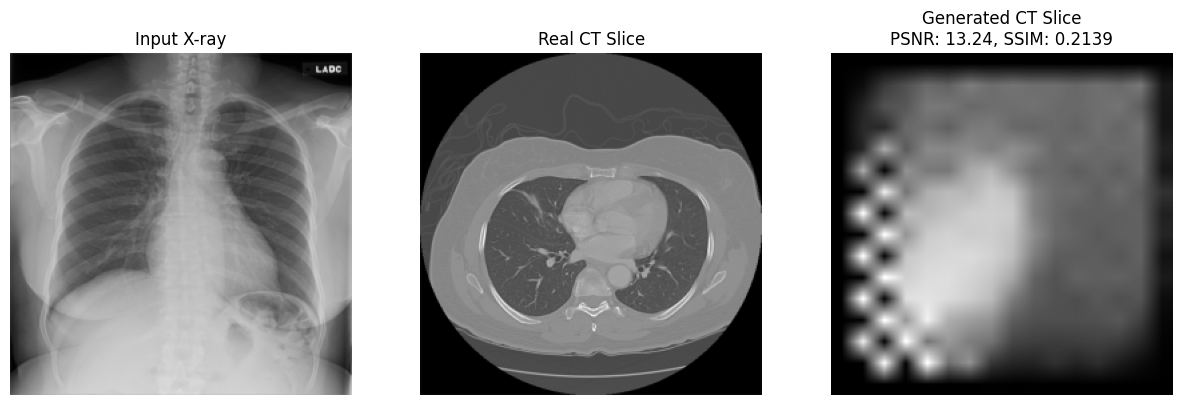

Patient ID: LIDC-IDRI-0185
X-ray image min: -0.9893885850906372, max: 0.936587393283844
CT slices min: -1.0, max: 0.9876922965049744
Patient ID: LIDC-IDRI-0102
X-ray image min: -1.0, max: 0.919241726398468
CT slices min: -1.0, max: 0.9978277683258057
Patient ID: LIDC-IDRI-0262
X-ray image min: -1.0, max: 0.8965447545051575
CT slices min: -1.0, max: 0.9999891519546509
Patient ID: LIDC-IDRI-0132
X-ray image min: -0.43838611245155334, max: 0.9110747575759888
CT slices min: -0.9999999403953552, max: 0.9999462366104126
Patient ID: LIDC-IDRI-0259
X-ray image min: -0.9506331086158752, max: 0.8409159779548645
CT slices min: -1.0, max: 1.0
Patient ID: LIDC-IDRI-0219
X-ray image min: -0.9419902563095093, max: 0.9781366586685181
CT slices min: -1.0, max: 1.0
Patient ID: LIDC-IDRI-0075
X-ray image min: -1.0, max: 0.8562523722648621
CT slices min: -1.0, max: 0.9851162433624268
Patient ID: LIDC-IDRI-0022
X-ray image min: -0.9844658374786377, max: 0.7746801376342773
CT slices min: -1.0, max: 1.0
Pati

In [ ]:
# Visualize results
visualize_results(generator, dataloader, device)

# Calculate metrics
calculate_metrics(generator, dataloader, device)

# Semi-Supervised Learning with ChestX-ray14

In [ ]:
# Load the saved model checkpoint trained up to epoch 50
checkpoint = torch.load('stylegan2ada_model_checkpoint.pth', map_location=device)

# Load model and optimizer states
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
scaler.load_state_dict(checkpoint['scaler_state_dict'])

# Set the starting epoch
start_epoch = checkpoint['epoch']  # This should be 50

In [ ]:
import os
from PIL import Image
from tqdm import tqdm  # For progress bar

# Ensure the generator is in evaluation mode
generator.eval()

# Path to the ChestX-ray14 dataset
chest_xray14_root = 'ChestX-ray14/'

# Directory to save the generated data
generated_data_root = 'StyleGAN2_Generated_LIDC-IDRI/'

# Create the root directory if it doesn't exist
os.makedirs(generated_data_root, exist_ok=True)

# Get the list of X-ray images
xray_image_paths = [os.path.join(chest_xray14_root, fname)
                    for fname in os.listdir(chest_xray14_root) if fname.endswith('.png')]

# Function to load and preprocess ChestX-ray14 images
def load_and_preprocess_chest_xray(image_path):
    # Load the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = np.array(image).astype(np.float32)

    # Normalize the image
    image_min = image.min()
    image_max = image.max()
    if image_max - image_min < epsilon:
        image = np.zeros_like(image)
    else:
        image = (image - image_min) / (image_max - image_min + epsilon)
        # Scale to [-1, 1] if using Tanh activation
        image = image * 2 - 1

    # Resize the image
    image = resize(image, (img_size, img_size), mode='constant', anti_aliasing=True)

    # Convert to tensor and add channel dimension
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return image_tensor

# Iterate over the ChestX-ray14 images and generate CT slices
for idx, xray_image_path in tqdm(enumerate(xray_image_paths), total=len(xray_image_paths)):
    # Create a unique patient ID
    patient_id = f'ChestXray14_{idx+1:05d}'
    patient_dir = os.path.join(generated_data_root, patient_id)
    ct_dir = os.path.join(patient_dir, 'CT')
    xray_dir = os.path.join(patient_dir, 'Xray')
    os.makedirs(ct_dir, exist_ok=True)
    os.makedirs(xray_dir, exist_ok=True)

    # Load and preprocess the X-ray image
    xray_tensor = load_and_preprocess_chest_xray(xray_image_path).to(device)

    # Sample random noise
    z = torch.randn(1, z_dim).to(device)

    # Generate CT slices
    with torch.no_grad():
        gen_ct = generator(xray_tensor, z)

    # Convert generated CT to numpy array
    gen_ct_np = gen_ct.squeeze().cpu().numpy()  # Shape: [ct_slices, img_size, img_size]

    # Save generated CT slices
    for i in range(ct_slices):
        slice_image = gen_ct_np[i]  # Shape: [img_size, img_size]
        # Normalize and convert to uint16
        slice_image = (slice_image - slice_image.min()) / (slice_image.max() - slice_image.min() + epsilon)
        slice_image_uint16 = ((slice_image + 1) / 2 * 65535).astype(np.uint16)  # Scale back to [0, 65535]
        # Save as PNG
        slice_filename = os.path.join(ct_dir, f'slice_{i:03d}.png')
        Image.fromarray(slice_image_uint16).save(slice_filename)

    # Save the preprocessed X-ray image
    xray_np = xray_tensor.squeeze().cpu().numpy()  # Shape: [img_size, img_size]
    xray_uint16 = ((xray_np + 1) / 2 * 65535).astype(np.uint16)  # Scale back to [0, 65535]
    xray_filename = os.path.join(xray_dir, 'xray.png')
    Image.fromarray(xray_uint16).save(xray_filename)


In [ ]:
# Modified Dataset class to include generated data
class CombinedXrayCTDataset(Dataset):
    def __init__(self, root_dirs):
        self.patient_dirs = []
        for root_dir in root_dirs:
            patients = sorted(os.listdir(root_dir))
            patients = [p for p in patients if os.path.isdir(os.path.join(root_dir, p))]
            self.patient_dirs.extend([os.path.join(root_dir, p) for p in patients])

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]

        # Load and preprocess X-ray image
        xray_path = glob(os.path.join(patient_dir, 'Xray', '*'))[0]
        xray = self.load_and_preprocess_image(xray_path)

        # Load and preprocess CT slices
        ct_dir = os.path.join(patient_dir, 'CT')
        ct_slice_paths = sorted(glob(os.path.join(ct_dir, '*')))
        ct_slices_array = self.load_and_preprocess_ct_slices(ct_slice_paths)

        sample = {'xray': xray, 'ct': ct_slices_array}

        return sample

    def load_and_preprocess_image(self, image_path):
        # Check if the image is DICOM or PNG
        if image_path.endswith('.dcm'):
            # Load DICOM image
            ds = pydicom.dcmread(image_path)
            image = ds.pixel_array.astype(np.float32)
        else:
            # Load PNG image
            image = Image.open(image_path).convert('L')
            image = np.array(image).astype(np.float32)

        # Normalize the image
        image = (image - image.min()) / (image.max() - image.min())

        # Resize the image
        image = resize(image, (img_size, img_size), mode='constant', anti_aliasing=True)

        # Convert to tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        return image

    def load_and_preprocess_ct_slices(self, slice_paths):
        num_slices = len(slice_paths)
        desired_slices = ct_slices

        # Calculate indices to select slices for alignment
        indices = np.linspace(0, num_slices - 1, desired_slices).astype(int)

        # Preallocate a list for the CT slices
        ct_slices_list = []
        for idx in indices:
            p = slice_paths[idx]
            # Load and preprocess each slice
            slice_ = self.load_and_preprocess_image(p)
            ct_slices_list.append(slice_)

        # Stack slices into a 3D volume
        ct_slices_array = torch.stack(ct_slices_list, dim=0)  # Shape: [ct_slices, 1, img_size, img_size]
        ct_slices_array = ct_slices_array.squeeze(1)  # Shape: [ct_slices, img_size, img_size]
        ct_slices_array = ct_slices_array.unsqueeze(0)  # Shape: [1, ct_slices, img_size, img_size]

        return ct_slices_array  # Return shape: [1, ct_slices, img_size, img_size]

In [ ]:
# Paths to the datasets
original_dataset_root = 'LIDC-IDRI/'
generated_dataset_root = 'StyleGAN2_Generated_LIDC-IDRI/'

# Create combined dataset and dataloader
combined_dataset = CombinedXrayCTDataset(root_dirs=[original_dataset_root, generated_dataset_root])
combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Reinitialize the optimizers if necessary
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.99))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0, 0.99))

In [ ]:
# Ensure models are on the correct device
generator.to(device)
discriminator.to(device)

# Set total number of epochs to train (70 epochs)
n_epochs = 70

# Training loop with the combined dataset
for epoch in range(start_epoch, n_epochs):
    for i, batch in enumerate(combined_dataloader):
        xray = batch['xray'].to(device, non_blocking=True)
        ct = batch['ct'].to(device, non_blocking=True)

        valid = torch.ones((xray.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((xray.size(0), 1), requires_grad=False).to(device)

        # Sample random noise
        z = torch.randn(xray.size(0), z_dim).to(device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        with autocast(device_type='cuda'):
            # Generate CT scans
            gen_ct = generator(xray, z)

            # Generator loss
            g_loss = adversarial_loss(discriminator(gen_ct, xray), valid)

        scaler.scale(g_loss).backward()
        scaler.step(optimizer_G)
        scaler.update()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        with autocast(device_type='cuda'):
            # Real CT loss
            real_loss = adversarial_loss(discriminator(ct, xray), valid)
            # Fake CT loss
            fake_loss = adversarial_loss(discriminator(gen_ct.detach(), xray), fake)
            # Total discriminator loss
            d_loss = 0.5 * (real_loss + fake_loss)

        scaler.scale(d_loss).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # Print training progress
        print(f"[Epoch {epoch+1}/{n_epochs}] [Batch {i+1}/{len(combined_dataloader)}] "
              f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

# ---------------------
#  Save Model Checkpoint
# ---------------------
# After training is done, save the updated model checkpoint

torch.save({
    'epoch': n_epochs,  # Total number of epochs trained (should be 70)
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
}, 'semi_sup_stylegan2_model_checkpoint.pth')

<ipython-input-22-ce248d3ba2f1>:41: RuntimeWarning: invalid value encountered in divide
  image = (image - image.min()) / (image.max() - image.min())
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:749: RuntimeWarning: All-NaN slice encountered
  and min_func(output_image) <= cval <= max_func(output_image)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


[Epoch 1/10] [Batch 1/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 2/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 3/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 4/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 5/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 6/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 7/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 8/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 9/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 10/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 11/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 12/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 13/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 14/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 15/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 16/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 17/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch 18/28] [D loss: nan] [G loss: nan]
[Epoch 1/10] [Batch

KeyboardInterrupt: 

In [ ]:
# Save the retrained models if desired
torch.save(generator.state_dict(), 'generator_retrained.pth')
torch.save(discriminator.state_dict(), 'discriminator_retrained.pth')

In [ ]:
# Visualize the results on the original dataset
visualize_results(generator, dataloader, device)

# Calculate and print metrics on the original dataset
calculate_metrics(generator, dataloader, device)